<a href="https://colab.research.google.com/github/kavyaLokuge/FDL/blob/main/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


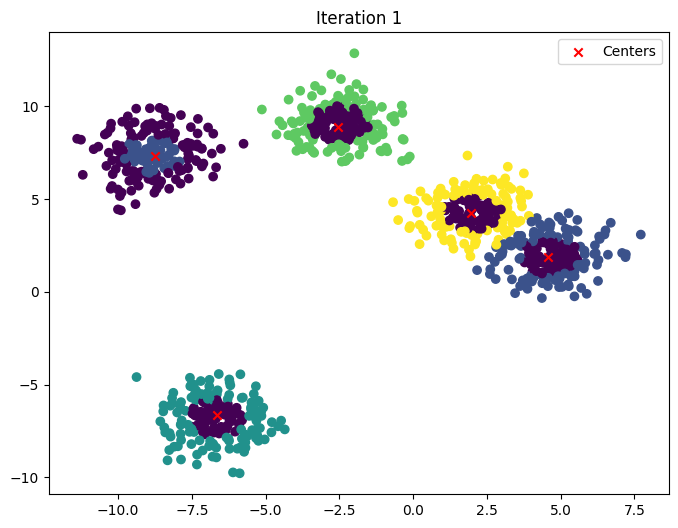

In [ ]:

import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
from sklearn.cluster import KMeans
import phe
from phe import paillier
from sklearn.metrics import silhouette_score, davies_bouldin_score


def calculate_pairwise_distances(X, centers):
    return np.linalg.norm(X[:, np.newaxis] - centers, axis=2)


class FuzzyCMeans:
    def __init__(self, num_clusters=5, max_iterations=100, m=2):
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations
        self.m = m
        self.cluster_centers_ = None

    def fit(self, X, initial_centers, learning_rate):
        self.cluster_centers_ = initial_centers
        prev_centers = initial_centers.copy()
        fig, ax = plt.subplots(figsize=(8, 6))
        for iteration in range(1, self.max_iterations + 1):
            distances = calculate_pairwise_distances(X, self.cluster_centers_)
            membership_matrix = self.calculate_membership(distances)

            alpha = learning_rate / iteration
            self.cluster_centers_ = self.calculate_cluster_centers(X, membership_matrix, alpha)

            if np.allclose(prev_centers, self.cluster_centers_):
                print(f"Convergence achieved at iteration {iteration}")
                break

            prev_centers = self.cluster_centers_

            # Plot data points and cluster centers
            ax.clear()
            ax.scatter(X[:, 0], X[:, 1], c=np.argmax(membership_matrix, axis=1), cmap='viridis')
            ax.scatter(self.cluster_centers_[:, 0], self.cluster_centers_[:, 1], c='red', marker='x', label='Centers')
            ax.set_title(f"Iteration {iteration}")
            # ax.set_title(f"OutPut")
            ax.legend()
            plt.pause(0.5)

        plt.show()

    def calculate_membership(self, distances):
        min_distances = np.min(distances, axis=1)
        membership_matrix = np.where(distances == min_distances[:, np.newaxis], 1.0,
                                     (1 / min_distances[:, np.newaxis]) ** (2 / (self.m - 1)))
        return membership_matrix

    def calculate_cluster_centers(self, X, membership_matrix, alpha):
        numerator = np.dot(membership_matrix.T ** self.m, X)
        denominator = np.sum(membership_matrix.T ** self.m, axis=1, keepdims=True)
        cluster_centers = self.cluster_centers_ + alpha * (numerator / denominator - self.cluster_centers_)
        return cluster_centers


class FederatedLearningServer:
    def __init__(self, num_clusters, num_clients, private_key):
        self.num_clusters = num_clusters
        self.num_clients = num_clients
        self.cluster_centers_ = None
        self.private_key = private_key

    def initialize_clusters(self, X):
        kmeans = KMeans(n_clusters=self.num_clusters, init='k-means++')
        kmeans.fit(X)
        self.cluster_centers_ = kmeans.cluster_centers_

    def update_clusters(self, client_updates):
        encrypted_aggregated_centers = client_updates[0]
        for update in client_updates[1:]:
            encrypted_aggregated_centers += update
        decrypted_aggregated_centers = np.array(
            [[self.private_key.decrypt(val) for val in row] for row in encrypted_aggregated_centers])
        self.cluster_centers_ = decrypted_aggregated_centers / len(client_updates)

    def get_cluster_centers(self):
        return self.cluster_centers_


class FederatedLearningClient:
    def __init__(self, data, public_key):
        self.data = data
        self.public_key = public_key

    def compute_cluster_centers(self, server_centers, learning_rate, iteration):
        fcm = FuzzyCMeans()
        fcm.fit(self.data, server_centers, learning_rate / (iteration + 1))
        cluster_centers = fcm.cluster_centers_
        encrypted_cluster_centers = self.encrypt_data(cluster_centers)
        return encrypted_cluster_centers

    def encrypt_data(self, data):
        encrypted_data = np.array([[self.public_key.encrypt(val) for val in row] for row in data])
        return encrypted_data


def main():
    num_clusters = 5
    num_clients = 10
    max_iterations = 500
    m = 2
    learning_rate = 0.01

    X, _ = make_blobs(n_samples=1000, centers=5, n_features=2, random_state=42)

    public_key, private_key = paillier.generate_paillier_keypair()

    server = FederatedLearningServer(num_clusters, num_clients, private_key)
    server.initialize_clusters(X)

    clients = []
    for i in range(num_clients):
        client_data = X[i * (X.shape[0] // num_clients):(i + 1) * (X.shape[0] // num_clients)]
        client= FederatedLearningClient(client_data, public_key)
        clients.append(client)

    num_jobs = min(num_clients, multiprocessing.cpu_count())  # Adjust the number of parallel jobs based on the available resources
    client_updates = Parallel(n_jobs=num_jobs)(delayed(client.compute_cluster_centers)(
        server.get_cluster_centers(), learning_rate, max_iterations) for client in clients)

    server.update_clusters(client_updates)

    fcm = FuzzyCMeans(num_clusters, max_iterations, m)
    fcm.cluster_centers_ = server.cluster_centers_
    fcm.fit(X, fcm.cluster_centers_, learning_rate)

    labels = np.argmax(fcm.calculate_membership(calculate_pairwise_distances(X, fcm.cluster_centers_)), axis=1)
    silhouette = silhouette_score(X, labels)
    print("Silhouette Score:", silhouette)

    davies_bouldin = davies_bouldin_score(X, labels)
    print("Davies-Bouldin Index:", davies_bouldin)


if __name__ == '__main__':
    main()



In [3]:
pip install phe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.6 MB/s eta 0:00:00


In [3]:
pip install phe